# Example Usage of VGGish for Generating Embeddings

This notebook demonstrates the complete VGGish pipeline end-to-end for a single audio file:

1. **Load audio** and generate its log-mel spectrogram (the input format VGGish expects)
2. **Run the spectrogram through VGGish** to produce a 128-dimensional embedding vector
3. **Post-process** the embedding using PCA, whitening, and quantization

[VGGish](https://github.com/tensorflow/models/tree/master/research/audioset/vggish) is a variant of the VGG image classification architecture adapted for audio. It was pre-trained on the [YouTube-8M AudioSet](https://research.google.com/audioset/) dataset (over 2 million human-labeled 10-second YouTube clips spanning 632 audio event classes). The network takes a 96x64 log-mel spectrogram as input and outputs a compact 128-dimensional embedding that captures the audio's semantic content.

## Step 1: Loading Audio and Generating the Spectrogram

The `vggish_input.wavfile_to_examples()` function handles the entire preprocessing pipeline:
1. Reads the WAV file and resamples to 16 kHz mono
2. Computes the STFT (Short-Time Fourier Transform) with a 25ms window and 10ms hop
3. Applies a mel filterbank with 64 bands (125 Hz to 7,500 Hz)
4. Takes the log of the mel spectrogram

The result is a 96x64 matrix -- 96 time frames by 64 mel frequency bands -- which is visualized below as a heatmap. This "image" is the input to the VGGish network. Brighter regions indicate higher energy at that time-frequency point.

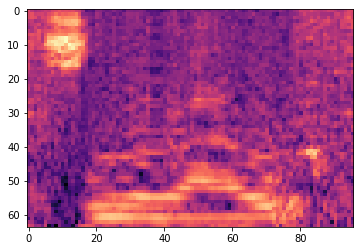

In [6]:
import sys
import matplotlib.pyplot as plt
import numpy as np
sys.path.append("/home/ubuntu/odsc/vggish/lib/models/research/audioset/vggish")

import vggish_input

fn = '/home/ubuntu/audio/speech_commands/zero/8a90cf67_nohash_0.wav'
spectrogram = vggish_input.wavfile_to_examples(fn)

plt.imshow(np.flip(spectrogram[0,:,:].T, axis=0), cmap='magma');

## Step 2: Defining the VGGish Network and Generating Embeddings

The VGGish model is an 11-layer deep CNN based on the VGG architecture:
- 4 groups of convolutional + max-pooling layers (for feature extraction)
- 2 fully connected layers (for feature compression)
- Final output: a **128-dimensional embedding vector**

We load the pre-trained checkpoint (`vggish_model.ckpt`) which contains weights learned from AudioSet. The network runs in **inference mode** (`training=False`) -- no weights are updated. We simply feed in the spectrogram and retrieve the embedding from the output tensor.

The embedding is a dense vector of 128 floating-point values that encodes the audio's acoustic characteristics. Semantically similar sounds will have similar embedding vectors, making these embeddings useful as features for downstream classifiers.

In [9]:
import tensorflow as tf
tf.disable_v2_behavior()

import vggish_slim, vggish_params

ckpt = '/home/ubuntu/odsc/vggish/lib/vggish_model.ckpt'

with tf.Graph().as_default(), tf.Session() as sess:
    vggish_slim.define_vggish_slim(training=False)
    vggish_slim.load_vggish_slim_checkpoint(sess, ckpt)
    features_tensor = sess.graph.get_tensor_by_name(
        vggish_params.INPUT_TENSOR_NAME)
    embedding_tensor = sess.graph.get_tensor_by_name(
        vggish_params.OUTPUT_TENSOR_NAME)
    
    [embedding_batch] = sess.run([embedding_tensor],
                                 feed_dict={features_tensor: spectrogram})

INFO:tensorflow:Restoring parameters from /home/ubuntu/odsc/vggish/lib/vggish_model.ckpt


In [16]:
embedding_batch

array([[0.        , 0.        , 0.5756371 , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.8052461 , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.09647734,
        0.        , 0.22157027, 0.36531267, 0.        , 0.        ,
        0.1050349 , 0.        , 0.4312849 , 0.        , 0.        ,
        0.        , 0.        , 0.09738243, 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.7165066 , 0.45736638,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.0754849 , 0.        , 0.04537962, 0.        , 0.        ,
        0.28914464, 0.        , 0.42669168, 0.        , 0.7256194 ,
        0.0045549 , 0.        , 0.        , 0.        , 0.        ,
        0.        , 1.1186049 , 0.        , 0.19068974, 0.01635714,
        0.        , 0.        , 0.        , 0.        , 0.07885516,
        0.        , 0.        , 0.15197024, 0.        , 0.02502064,
        0.        , 0.        , 0.        , 0.  

## Step 3: Post-Processing

The VGGish authors provide an optional post-processing step designed for compatibility with the YouTube-8M classification pipeline. This step applies:

1. **PCA (Principal Component Analysis)**: Projects the 128-dim embedding into a decorrelated 128-dim space using a pre-computed PCA matrix
2. **Whitening**: Normalizes the variance along each PCA dimension
3. **Quantization**: Clips values to [-2, +2], then linearly maps to unsigned 8-bit integers (0-255)

The result is a compact `uint8` vector that is more storage-efficient than the raw float32 embedding. For the downstream classification tasks in this project, we use the **raw float32 embeddings** rather than the post-processed version, as the quantization step discards some information.

## Post-processing

In [17]:
import vggish_postprocess

pca_params = '/home/ubuntu/odsc/vggish/lib/vggish_pca_params.npz'
pproc = vggish_postprocess.Postprocessor(pca_params)

postprocessed_batch = pproc.postprocess(embedding_batch)

In [18]:
postprocessed_batch

array([[158,  14, 154, 100, 205,  72, 121,  65, 132, 249,  96,  86, 101,
        154,  70, 161, 100, 100, 163, 121,  16, 255, 134,  67,  66, 131,
        168, 210,  64, 186, 228, 102,  32,  75,   0, 219,  46,   0, 148,
        152,   0, 197,  96,  92, 187, 111, 255, 193,  93, 225, 160,  82,
         91,  76, 115, 106, 255,  42, 149, 137, 117,  93,  45, 220,  83,
         90, 144,   4, 129, 190, 136, 140, 172,  64, 108, 132,   0, 255,
         15,  48,  16,  92, 161, 101,  82, 158, 127, 145, 255,  32, 255,
        129,  52,   6, 149, 255, 218,  98, 253, 218,  47, 135, 255, 173,
          0,   0,  50,  45, 255,  78, 140,  85,  84,  41, 255,   0,  76,
        247,   0, 167, 123, 116,  13,   0, 168,   0, 178, 255]],
      dtype=uint8)